# Problem set 5: APIs, SQL, and supervised machine learning

**Total points (without extra credit)**: 56 


## Resources from class

### APIs
- [Lecture slides](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/10_qss20_w23_APIs.pdf)
- [Activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/06_apis_solutions.ipynb)
- [DataCamp chapter](https://app.datacamp.com/learn/courses/intermediate-importing-data-in-python)

### Supervised ML
- [Lecture slides](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/12_qss20_w23_supervisedML.pdf)
- [Intro activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/08_ML_intro_activity_solutions.ipynb)
- [Part II activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/08_ML_optimization_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/supervised-learning-with-scikit-learn)

### SQL
- [Lecture slides](https://github.com/jhaber-zz/QSS20_public/blob/main/slides/13_qss20_w23_SQL.pdf)
- [Example code](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/109_SQL_examplecode.ipynb)
- [Activity solutions](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/09_SQL_activity_solutions.ipynb)
- [DataCamp course](https://app.datacamp.com/learn/courses/introduction-to-sql)

# Prep work: obtain an API key for the US Census (the American Community Survey)

- Obtain a census API key from [this request page](https://api.census.gov/data/key_signup.html)
- Place it in [the same credentials yaml file on GitHub that contains the SQL database access information](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/09_db_cred.yaml) (password, host, etc.) 
    - Name the combined credentials file something appropriate (feel free to get creative)
    - Change the database name from `sentencing` to `math_gencompare`

## 0.0 Import packages

**Note you need to install some of the packages imported below (see the comments).**

In [1]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import yaml
#import warnings
#warnings.filterwarnings("ignore")

## note: you may need to install these using !pip install
!pip install census
!pip install us
import census
from census import Census
import us
from us import states
import mysql.connector

## sklearn imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity on APIs (see link above), we practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data and writing a wrapper function.
    
As a reminder, the documentation is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 
- stattype = MN (for mean)

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [2]:
query = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015')

eighth_resp = requests.get(query)
eighth_resp

eighth_j = eighth_resp.json()
eighth_j

eighth = pd.DataFrame(eighth_j["result"])
eighth

## Females score slightly higher in math than males, by .6 of a point. 

<Response [200]>

{'status': 200,
 'result': [{'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 275.020976636682,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 275.638637274477,
   'isStatDisplayable': 1,
   'errorFlag': 0}]}

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  275.020977                  1          0
1  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  275.638637                  1          0

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as 1.1 but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to combine) in one query

In [3]:
query2 = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019')

eighth_resp_2 = requests.get(query2)
eighth_resp_2

eighth_j_2 = eighth_resp_2.json()
eighth_j_2

eighth2 = pd.DataFrame(eighth_j_2["result"])
eighth2

<Response [200]>

{'status': 200,
 'result': [{'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '1',
   'varValueLabel': 'Male',
   'value': 277.167170641967,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2013,
   'sample': 'R3',
   'yearSampleLabel': '2013',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'scale': 'MRPCM',
   'jurisdiction': 'CA',
   'variable': 'GENDER',
   'variableLabel': 'Gender',
   'varValue': '2',
   'varValueLabel': 'Female',
   'value': 274.597823860242,
   'isStatDisplayable': 1,
   'errorFlag': 0},
  {'year': 2015,
   'sample': 'R3',
   'yearSampleLabel': '2015',
   'Cohort': 2,
   'CohortLabel': 'Grade 8',
   'stattype': 'MN:MN',
   'subject': 'MAT',
   'grade': 8,
   'sca

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  277.167171                  1          0
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  274.597824                  1          0
2  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  275.020977                  1          0
3  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  275.638637                  1          0
4  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  276.608704                  1          0
5  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  276.669430                  1          0
6  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  274.511628                  1          0
7  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  276.721824                  1          0

## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis at 270 and add informative labels. Be sure your x-axis is ticked on odd years, because NAEP scores skip even years. 

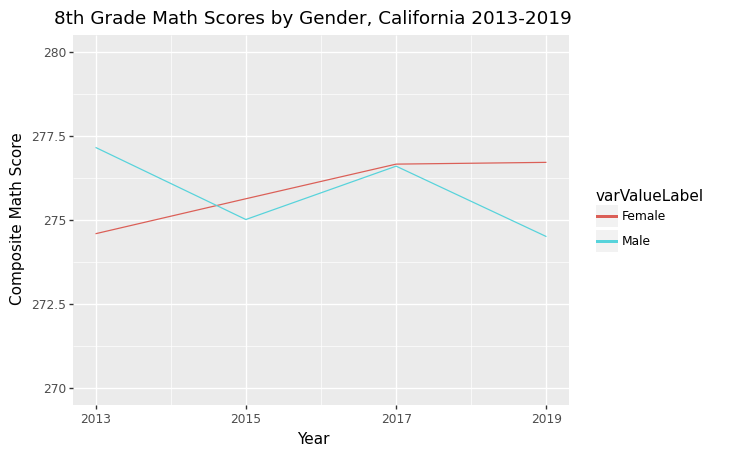

<ggplot: (8792519484925)>

In [4]:
(ggplot(data=eighth2, mapping=aes(x="year", y="value", color="varValueLabel")) +
    geom_line() +
    scale_y_continuous(limits=[270, 280]) +
    scale_x_continuous(breaks=[2013, 2015, 2017, 2019]) +
    labs(x="Year",
         y="Composite Math Score",
         title="8th Grade Math Scores by Gender, California 2013-2019"))

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [5]:
def construct_naep_query(years: list, place: str):
    
    base1 = """https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction="""
            
    base2 = '&stattype=MN:MN&Year=' 
    
    year_str = ''
    for year in years:
        year_str += (str(year) + ",")
        
    final = year_str[:-1]
        
    query = base1 + place + base2 + final
    
    print(query)
    
    return query
    

In [6]:
assert construct_naep_query([2015], "CA") == query

assert construct_naep_query([2013, 2015, 2017, 2019], "CA") == query2

https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019


## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the CA-specific NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see [API part 1 solutions code](https://github.com/jhaber-zz/QSS20_public/blob/main/activities/solutions/08_apis_partI_solutions.ipynb) for an example of `try:`/`except:`)

- Execute the function on the query that pulls 2013-2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [7]:
def process_naep_query(query):
    
    try:
        resp = requests.get(query)
        
        json = resp.json()
    except:
        return "Data not found; check your query"
    
    
    
    output = pd.DataFrame(json["result"])
    
    return output

In [8]:
process_naep_query(construct_naep_query([2013, 2015, 2017, 2019], "CA"))

process_naep_query(construct_naep_query([2013, 2015, 2017, 2019], "ZZ"))

https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019


year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  277.167171                  1          0
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  274.597824                  1          0
2  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  275.020977                  1          0
3  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  275.638637                  1          0
4  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  276.608704                  1          0
5  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  276.669430                  1          0
6  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        1          Male  274.511628                  1          0
7  2019     R3            2019       2     Grade 8    MN:MN     MAT      8  MRPCM           CA   GENDER        Gender        2        Female  276.721824                  1          0

https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=ZZ&stattype=MN:MN&Year=2013,2015,2017,2019


'Data not found; check your query'

# 2. Explore data using SQL queries (18 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

## 2.1 Load database credentials and establish a connection (1 point)

Load a credentials file that contains the credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

Note: to establish the SQL connection, you need to be on `eduroam` (near campus) or the Dartmouth's GlobalProtect `VPN`  ([installation instructions here](https://services.dartmouth.edu/TDClient/1806/Portal/KB/?CategoryID=17668))

In [9]:
creds = load_creds("09_db_cred.yaml")

cnx = mysql.connector.connect(user=creds['practice_database']['user'], 
                            password=creds['practice_database']['password'],
                            port=creds['practice_database']['port'],
                            database= creds['practice_database']['database'],
                            host = creds['practice_database']['host'])
cnx

## 2.2 Run a query to select all columns and the first 5 rows of the math_gencompare database to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [10]:
query1 = """
SELECT *
FROM math_gencompare
LIMIT 5

"""

output1 = pd.read_sql_query(query1, cnx)
output1

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/3045614528.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


abbrev  FIPS       state  year            female              male is_early_vote
0     AK     2      Alaska  2013  281.388243030547  281.723376175464          None
1     AL     1     Alabama  2013  268.920111754346  269.457455785562          None
2     AR     5    Arkansas  2013  278.381788404903  277.457662328569          None
3     AZ     4     Arizona  2013  279.249581150207  280.174388600923          None
4     CA     6  California  2013  274.597823860242  277.167170641967          None

## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?

**Hint**: rather than using count `(*)` for the latter two, think about the `distinct` command in combination with `count`: https://www.w3resource.com/mysql/aggregate-functions-and-grouping/aggregate-functions-and-grouping-count-with-distinct.php

In [11]:
# number of rows
query2 = """
SELECT COUNT(1)
FROM math_gencompare
"""

output2 = pd.read_sql_query(query2, cnx)
output2

# number of distinct states
query2 = """
SELECT COUNT(DISTINCT state)
FROM math_gencompare
"""

output2 = pd.read_sql_query(query2, cnx)
output2

# number of distinct years
query3 = """
SELECT COUNT(DISTINCT year)
FROM math_gencompare
"""

output3 = pd.read_sql_query(query3, cnx)
output3

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/1616871795.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


COUNT(1)
0       200

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/1616871795.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


COUNT(DISTINCT state)
0                     50

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/1616871795.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


COUNT(DISTINCT year)
0                     4

## 2.4 Construct a new variable, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [12]:

query4 = """
SELECT *,
CASE
    WHEN female < male THEN 1
    ELSE 0
END as is_male_higher
FROM math_gencompare
    
"""

output4 = pd.read_sql_query(query4, cnx)
output4.head()
output4.is_male_higher.mean()

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/2688639051.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


abbrev  FIPS       state  year            female              male is_early_vote  is_male_higher
0     AK     2      Alaska  2013  281.388243030547  281.723376175464          None               1
1     AL     1     Alabama  2013  268.920111754346  269.457455785562          None               1
2     AR     5    Arkansas  2013  278.381788404903  277.457662328569          None               0
3     AZ     4     Arizona  2013  279.249581150207  280.174388600923          None               1
4     CA     6  California  2013  274.597823860242  277.167170641967          None               1

0.515

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states that have higher scores for males than females in this year 

**B.** Print the resulting dataframe and interpret the results 

**Hint:** To compare male and female scores, consider logical operators (e.g., `<`, `>`, `=`) and simple aggregation (e.g., `avg()` to get mean) or using a subquery to construct the indicator.

In [13]:
query5 = """
SELECT math_gencompare.year, AVG(is_male_higher)
FROM math_gencompare
INNER JOIN (SELECT *,
CASE
    WHEN female < male THEN 1
    ELSE 0
END as is_male_higher
FROM math_gencompare) AS temp 
ON temp.state = math_gencompare.state
AND temp.year = math_gencompare.year
GROUP BY math_gencompare.year
    
"""

output5 = pd.read_sql_query(query5, cnx)
output5

## Interpretation: As the years progress, there is a lower precentage 
## of states where males have a higher score than females

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/4109665295.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


year  AVG(is_male_higher)
0  2013                 0.62
1  2015                 0.56
2  2017                 0.58
3  2019                 0.30

## 2.6 group by state and find the percentage of years where male scores higher than females

**A.** Write a query that (1) groups by state and (2) finds the percentage of years that have higher scores for males than females in that state

**B.** Plot the results ordering the states from males higher all 4 years to males higher none of the years

In [14]:
query6 = """
SELECT math_gencompare.state, AVG(is_male_higher) as state_average
FROM math_gencompare
INNER JOIN (SELECT *,
CASE
    WHEN female < male THEN 1
    ELSE 0
END as is_male_higher
FROM math_gencompare) AS temp 
ON temp.state = math_gencompare.state
AND temp.year = math_gencompare.year
GROUP BY math_gencompare.state
ORDER BY state_average DESC
    
"""

output6 = pd.read_sql_query(query6, cnx)
output6

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/624166497.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


state  state_average
0             Utah           1.00
1         Illinois           1.00
2            Idaho           1.00
3           Alaska           0.75
4    New Hampshire           0.75
5       New Jersey           0.75
6       New Mexico           0.75
7           Nevada           0.75
8            Maine           0.75
9           Kansas           0.75
10         Indiana           0.75
11         Georgia           0.75
12         Florida           0.75
13      Washington           0.75
14        Colorado           0.75
15   West Virginia           0.75
16         Arizona           0.75
17       Tennessee           0.50
18           Texas           0.50
19    Rhode Island           0.50
20          Oregon           0.50
21        Oklahoma           0.50
22            Ohio           0.50
23        New York           0.50
24         Wyoming           0.50
25         Alabama           0.50
26        Nebraska           0.50
27        Arkansas           0.50
28        Missouri           0.50
29       Minnesota           0.50
30        Michigan           0.50
31        Maryland           0.50
32     Connecticut           0.50
33    North Dakota           0.50
34        Delaware           0.50
35            Iowa           0.50
36        Kentucky           0.25
37      California           0.25
38       Wisconsin           0.25
39         Vermont           0.25
40        Virginia           0.25
41    South Dakota           0.25
42  South Carolina           0.25
43    Pennsylvania           0.25
44       Louisiana           0.25
45   Massachusetts           0.25
46         Montana           0.25
47          Hawaii           0.00
48     Mississippi           0.00
49  North Carolina           0.00

## 2.7 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_vote` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list of states we provide and using something like `format`. Hint on how to combine the state names while preserving the quotes around each: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by the `is_early_vote` indicator and `year` and find the percencentage of states in each group where males had higher scores than females 

**C.** Print the resulting dataframe and interpret. Does early expansion of voting seem to be correlated with girls scoring better on the math tests a century later?

**Hint:** in order to group by the indicator in step b, you may need to use a subquery 

In [15]:
## list of states we provide
list_suffrage = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]


In [16]:
list_str = ', '.join(f'"{state}"' for state in list_suffrage)
print(list_str)

"Wyoming", "Colorado", "Utah", "Idaho", "Washington", "California"


In [18]:
query7 = """
SELECT math_gencompare.year, temp1.early_vote_state, AVG(is_male_higher) as state_average
FROM math_gencompare
INNER JOIN (SELECT *,
CASE
    WHEN female < male THEN 1
    ELSE 0
END as is_male_higher
FROM math_gencompare) AS temp 
ON temp.state = math_gencompare.state
AND temp.year = math_gencompare.year
INNER JOIN (SELECT *,
CASE
    WHEN state IN (""" + list_str + """) THEN 1
    ELSE 0
END AS early_vote_state
FROM math_gencompare) AS temp1
ON temp1.state = math_gencompare.state
AND temp1.year = math_gencompare.year
GROUP BY math_gencompare.year, temp1.early_vote_state
    
"""

output7 = pd.read_sql_query(query7, cnx)
output7

## Interpret: It seems like expanding voting rights to women does not correlate with girls scoring higher on math
## tests a century later. Though female scores are increasing for all states as time progresses, the states that 
## expanded access are much more likely to have higher male scores, by between .2 and .3 probability points. 

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/107500315.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


year  early_vote_state  state_average
0  2013                 0         0.5909
1  2013                 1         0.8333
2  2015                 0         0.5455
3  2015                 1         0.6667
4  2017                 0         0.5455
5  2017                 1         0.8333
6  2019                 0         0.2727
7  2019                 1         0.5000

# 3. Pull state-level attributes using Census API (8 points)

You want to explain the variation you see across states in gender gaps in test scores by looking at demographics of the state population. To do so, we'll pull demographics from the American Community Survey (ACS), a US Census data product discussed more here: https://en.wikipedia.org/wiki/American_Community_Survey

## 3.1 Initialize Census API connection using API key (0 points)

- Load the credentials yaml file with the Census API key
- Initialize the Census API connection using API key and the `census` package
    - Documentation here for the `census` package on establishing an API connection: https://github.com/datamade/census

In [19]:
import yaml
from census import Census

with open('credentials.yaml', 'r') as f:
    credentials = yaml.safe_load(f)

c = Census(credentials['api_key'])

## 3.2 Run this function (feeding it your api connection) to get a list of variables to pull (0 points)

Feed the connection to the API you created in previous step (if you print type it's a census.core.Census class) to the `your_connection` argument in the function)

In [20]:
## keep in blank
to_pull = ['RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS',
          'ALLOCATION OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS - PERCENT OF INCOME ALLOCATED',
          'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)',
          'EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER',
          'HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP']

In [21]:
## keep in blank
def get_acs_varnames(your_connection):
    
    ## get tables for the acs 5-year estimates
    all_tables = pd.DataFrame(your_connection.acs5.tables(year = 2018))
    
    ## specify the ones to pull
    info_topull = all_tables[all_tables.description.isin(to_pull)].copy()
    
    ## use raw api to get varnames within those tables
    all_vars = [pd.DataFrame(requests.get(one_table).json()['variables']).T
                for one_table in info_topull.variables]
    all_vars_df = pd.concat(all_vars)
    all_vars_df['varname'] = all_vars_df.index
    
    ## subset to relevant
    all_vars_df_subset = all_vars_df[['varname', 'group', 'label',
                                    'concept']].copy()
    all_vars_df_est = all_vars_df_subset[all_vars_df.varname.str.contains("E$", 
                                        regex = True)].copy()
    return(all_vars_df_est)
    

In [22]:
## NOTE: replace the your_connection with your 
## connection to the Census API
acs_cols = get_acs_varnames(c)
acs_cols.head()
print(acs_cols.columns)

varname   group                          label                                                             concept
B17026_003E  B17026_003E  B17026    Estimate!!Total!!.50 to .74  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_004E  B17026_004E  B17026    Estimate!!Total!!.75 to .99  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_001E  B17026_001E  B17026                Estimate!!Total  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_002E  B17026_002E  B17026     Estimate!!Total!!Under .50  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_007E  B17026_007E  B17026  Estimate!!Total!!1.50 to 1.74  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS

Index(['varname', 'group', 'label', 'concept'], dtype='object')


## 3.3 Pull the variables for all 50 states (8 points)

**A.** Use list comprehension to pull these variables for every state (each FIPS code) using the `acs5.state` method for the year 2013.
- **Hint 1:** See the documentation for how to feed it variables to pull (requires a tuple); the documentation shows an example state--`MD`. You can find the other `FIPS` Ccodes for states in the `states` object in `us` package you loaded above): https://github.com/datamade/census/blob/70e2c08710c1e10e5bc2054b78613fa8794d4765/README.rst
- **Hint 2:** You can feed the tuple of ACS variable names to the function you'll use to pull Census/ACS data; you should NOT need to iterate over individual vars when pulling.
- **Note**: this takes ~1-2 minutes to run on our machine

**B.** Transform the result (which is a list of json) into a list of dataframes. Then concatenate and melt (on state) into one dataframe

**C.** Merge with the `all_states_fips` df, then merge that with `acs_cols` from 3.2 (on varname and variable) to know both which states the variables correspond to and the more informative variable names 

Call the final output `acs_df_forperc` so you can run the next code we provide

In [23]:
## run this code- keep in blank
## NOTE: you need to have the us package
## installed and imported
cols_pull = tuple(acs_cols.varname) # tuple form of the acs variable names to pull
all_states = states.STATES
all_states_fips = pd.DataFrame({'FIPS':
                    [one_state.fips for one_state in all_states],
                    'state': [one_state.name for one_state in all_states],
                'abbrev': [one_state.abbr for one_state in all_states]})
all_states_fips

FIPS           state abbrev
0    01         Alabama     AL
1    02          Alaska     AK
2    04         Arizona     AZ
3    05        Arkansas     AR
4    06      California     CA
5    08        Colorado     CO
6    09     Connecticut     CT
7    10        Delaware     DE
8    12         Florida     FL
9    13         Georgia     GA
10   15          Hawaii     HI
11   16           Idaho     ID
12   17        Illinois     IL
13   18         Indiana     IN
14   19            Iowa     IA
15   20          Kansas     KS
16   21        Kentucky     KY
17   22       Louisiana     LA
18   23           Maine     ME
19   24        Maryland     MD
20   25   Massachusetts     MA
21   26        Michigan     MI
22   27       Minnesota     MN
23   28     Mississippi     MS
24   29        Missouri     MO
25   30         Montana     MT
26   31        Nebraska     NE
27   32          Nevada     NV
28   33   New Hampshire     NH
29   34      New Jersey     NJ
30   35      New Mexico     NM
31   36        New York     NY
32   37  North Carolina     NC
33   38    North Dakota     ND
34   39            Ohio     OH
35   40        Oklahoma     OK
36   41          Oregon     OR
37   42    Pennsylvania     PA
38   44    Rhode Island     RI
39   45  South Carolina     SC
40   46    South Dakota     SD
41   47       Tennessee     TN
42   48           Texas     TX
43   49            Utah     UT
44   50         Vermont     VT
45   51        Virginia     VA
46   53      Washington     WA
47   54   West Virginia     WV
48   55       Wisconsin     WI
49   56         Wyoming     WY

In [24]:
# your code here for remainder
# FIPS codes for all 50 states
states = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12',
          '13', '15', '16', '17', '18', '19', '20', '21', '22', '23',
          '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
          '34', '35', '36', '37', '38', '39', '40', '41', '42', '44',
          '45', '46', '47', '48', '49', '50', '51', '53', '54', '55',
          '56']

acs_var = [pd.DataFrame(c.acs5.state(('NAME', *acs_cols.varname), state, year=2013))
          for state in states]


# Concat and melt
acs_df_list = [pd.DataFrame(var) for var in acs_var]
acs_df = pd.concat(acs_df_list)
acs_df = acs_df.melt(id_vars=['state'], var_name='variable', value_name='value')


# Merge with all_states_fips
acs_df_forperc = pd.merge(acs_df, all_states_fips, how='inner', left_on=['state'], right_on = ['FIPS'])

# Merge with acs_cols 
acs_df_forperc = pd.merge(acs_df_forperc, acs_cols, left_on=['variable'], right_on=['varname'])

acs_df_forperc




state_x     variable     value FIPS        state_y abbrev      varname   group                                                                                      label                                                             concept
0         01  B17026_003E   50074.0   01        Alabama     AL  B17026_003E  B17026                                                                Estimate!!Total!!.50 to .74  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
1         02  B17026_003E    3056.0   02         Alaska     AK  B17026_003E  B17026                                                                Estimate!!Total!!.50 to .74  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
2         04  B17026_003E   55487.0   04        Arizona     AZ  B17026_003E  B17026                                                                Estimate!!Total!!.50 to .74  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
3         05  B17026_003E   31249.0   05       Arkansas     AR  B17026_003E  B17026                                                                Estimate!!Total!!.50 to .74  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
4         06  B17026_003E  292341.0   06     California     CA  B17026_003E  B17026                                                                Estimate!!Total!!.50 to .74  RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
...      ...          ...       ...  ...            ...    ...          ...     ...                                                                                        ...                                                                 ...
4245      51  B09019_020E   32425.0   51       Virginia     VA  B09019_020E  B09019  Estimate!!Total!!In households!!In family households!!Nonrelatives!!Housemate or roommate             HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP
4246      53  B09019_020E   31532.0   53     Washington     WA  B09019_020E  B09019  Estimate!!Total!!In households!!In family households!!Nonrelatives!!Housemate or roommate             HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP
4247      54  B09019_020E    3701.0   54  West Virginia     WV  B09019_020E  B09019  Estimate!!Total!!In households!!In family households!!Nonrelatives!!Housemate or roommate             HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP
4248      55  B09019_020E   11985.0   55      Wisconsin     WI  B09019_020E  B09019  Estimate!!Total!!In households!!In family households!!Nonrelatives!!Housemate or roommate             HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP
4249      56  B09019_020E    2273.0   56        Wyoming     WY  B09019_020E  B09019  Estimate!!Total!!In households!!In family households!!Nonrelatives!!Housemate or roommate             HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP

[4250 rows x 10 columns]

## 3.4 run code to transform counts into percentages (0 points)

- Run the following code to transform the ACS counts in `acs_df_forperc` into percentages

Note: You may see a warning from the str.split step; feel free to ignore it


In [25]:
def create_percentages(df, name_estimatecol = 'estimate'):
    
    ## remove cols that dont need percentages
    df_forperc = df[~df.perc_NA].copy()
    
    ## sort by 
    
    ## group by location and variable prefix 
    group_co_tract_varg = df_forperc.groupby(['FIPS', 'variable_prefix'])
    
    ## iterate over groups
    df_longperc = []
    for group, data_raw in group_co_tract_varg:
        prefix = data_raw.variable_prefix.iloc[0]
        FIPS = data_raw.FIPS.iloc[0]
        row_list_group = []
        data = data_raw.sort_values(by = 'variable_suffix')
        for i in range(1, data.shape[0]):
            numerator = data[name_estimatecol].iloc[i]
            denominator = float(data[name_estimatecol].iloc[0])
            if denominator == 0:
                denominator = np.nan
            if denominator != 0:
                percentage = numerator / denominator
                row = [prefix, FIPS]
                row = row + [data.variable_suffix.iloc[i], percentage]
                row_list_group.append(row)
        df_longperc.append(pd.DataFrame(row_list_group))
    percentages_all_groups = pd.concat(df_longperc)
    percentages_all_groups.columns = ['variable_prefix',"FIPS",
                                  'variable_suffix', 'percentage']
    percentages_all_groups['percentage'] = percentages_all_groups.percentage.astype(float)
    return(percentages_all_groups)



In [26]:
varnames_percnotrelevant = ["B19013_001E"]

## create prefix and suffix columns
acs_df_forperc['variable_prefix'], acs_df_forperc['variable_suffix'] = \
                                acs_df_forperc['varname'].str.split('_', 1).str
acs_df_forperc['perc_NA'] = np.where(acs_df_forperc.varname.isin(varnames_percnotrelevant),
                                  True, False)
acs_df_forperc = acs_df_forperc[acs_df_forperc.variable != "GEO_ID"].copy()

perc_long = create_percentages(acs_df_forperc, 'value').sort_values(by = 'variable_prefix')

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/1754204118.py:5: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/1754204118.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


In [27]:
perc_long_wnames = pd.merge(perc_long,
                           acs_df_forperc,
                           on = ['variable_prefix', 'variable_suffix', 'FIPS'],
                           how = "right")
perc_long_wnames['value'] = perc_long_wnames.value.astype(float)

perc_long_wnames['percentage'] = np.where(perc_long_wnames.perc_NA,
                                         perc_long_wnames.value,
                                         perc_long_wnames.percentage)
perc_long_wnames['varname_words'] = "acspredict_" + perc_long_wnames.concept.str.replace("\s+|\(|\)", "_", 
                                    regex = True).str.lower() + \
                            perc_long_wnames.label.str.replace("\.|\!|\,|\(|\)|\-", 
                                    "", regex = True).str.lower() 

perc_long_wnames_final = perc_long_wnames[['FIPS', 'percentage', 
                                          'varname_words']].copy()


perc_wide = pd.pivot_table(perc_long_wnames_final, 
                           index = 'FIPS',
                          columns='varname_words',
                            values='percentage').reset_index()

## merge state info back on
perc_wide_wstate = pd.merge(perc_wide,
                           all_states_fips,
                           on = "FIPS",
                           how = "left")


In [28]:
perc_wide_wstate.head()

FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
1   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
2   04                                                                                                                                                                                             0.016991                                                                                                                                                                              0.162019                                                                                                                                                                                             0.026034                                                                                                                                                                                              0.045632                                                                                                                                                         0.025682   
3   05                                                                                                                                                                                             0.018760                   

## 3.5 extra credit (2 points)

Use list comprehension and NAEP query creation/process results functions you created above to iterate over state abbreviations in `all_states_fips` and pull the same test score gap information

If skipping, you'll read in pkl at next step

**Note**: this took 2 mins to run on my machine

In [29]:
def construct_naep_query(years: list, place: str):
    
    base1 = """https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction="""
            
    base2 = '&stattype=MN:MN&Year=' 
    
    year_str = ''
    for year in years:
        year_str += (str(year) + ",")
        
    final = year_str[:-1]
        
    query = base1 + place + base2 + final
    
    print(query)
    
    return query
    
def process_naep_query(query):
    
    try:
        resp = requests.get(query)
        
        json = resp.json()
    except:
        return "Data not found; check your query"
       
    output = pd.DataFrame(json["result"])
    
    return output

years = [2013, 2015, 2017, 2019]

state_gaps = [process_naep_query(construct_naep_query(years, state)) for state in all_states_fips['abbrev']]

# First five rows of the first dataframe in state_gaps
state_gaps[0].head()

https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=AL&stattype=MN:MN&Year=2013,2015,2017,2019
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=AK&stattype=MN:MN&Year=2013,2015,2017,2019
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=AZ&stattype=MN:MN&Year=2013,2015,2017,2019
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=AR&stattype=MN:MN&Year=2013,2015,2017,2019
https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019
https://www.nationsreportcard.gov/Dataservice/GetAdhocD

year sample yearSampleLabel  Cohort CohortLabel stattype subject  grade  scale jurisdiction variable variableLabel varValue varValueLabel       value  isStatDisplayable  errorFlag
0  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           AL   GENDER        Gender        1          Male  269.457456                  1          0
1  2013     R3            2013       2     Grade 8    MN:MN     MAT      8  MRPCM           AL   GENDER        Gender        2        Female  268.920112                  1          0
2  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           AL   GENDER        Gender        1          Male  266.304405                  1          0
3  2015     R3            2015       2     Grade 8    MN:MN     MAT      8  MRPCM           AL   GENDER        Gender        2        Female  266.810672                  1          0
4  2017     R3            2017       2     Grade 8    MN:MN     MAT      8  MRPCM           AL   GENDER        Gender        1          Male  269.820070                  1          0

# 4. Explore variation in math score disparities and trends (18 points)

## 4.0 Read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [30]:
## your code here
acs_wmath = pd.read_pickle("acs_wmath.pkl")
acs_wmath.head()


math_female_2013  math_female_2015  math_female_2017  math_female_2019  math_male_2013  math_male_2015  math_male_2017  math_male_2019 abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  \
0        281.388243        280.879362        276.557200        271.915723      281.723376      280.143705      277.451445      276.639877     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986   
1        268.920112        266.810672        266.748589        270.473059      269.457456      266.304405      269.820070      267.093325     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773   
2        278.381788        274.793326        273.139254        276.007484      277.457662      275.325959      274.352754      272.827299     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808   
3        279.249581        282.593875        279.935438        280.527631      280.174389      283.229891      284.522633      279.359156     AZ   04                                                                                                                                                  

## 4.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


In [31]:
## your code here
import matplotlib.pyplot as plt

df = acs_wmath[['state', 'math_male_2013', 'math_female_2013']]
df['gender_disparity'] = df['math_male_2013'] - df['math_female_2013']
colors = ['red' if val < 0 else 'blue' for val in df['gender_disparity']]

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(df['gender_disparity'], df['state'], color=colors)

# Add axis labels and a title
ax.set_xlabel('Male 2013 math scores - Female 2013 math scores (gender disparity)')
ax.set_ylabel('State')
ax.set_title('Gender disparity in 2013 math scores by state')

plt.show()

/var/folders/0x/rl39d06x18d0p7tvgzg1rq340000gn/T/ipykernel_38272/3558303713.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 0, 'Male 2013 math scores - Female 2013 math scores (gender disparity)')

Text(0, 0.5, 'State')

Text(0.5, 1.0, 'Gender disparity in 2013 math scores by state')

## 4.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a smoothed scatterplot of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations - in states with higher median household income (MHI), do 
   - boys tend to perform better than boys in states with lower MHI?
   - girls tend to perform better than girls in states with lower MHI?
   - boys tend to outperform girls more than they do in states with lower MHI?

In [32]:
# your code here 
# Part A
# create indicator variable for better performance of males in 2013 than females
acs_wmath['male_better_than_female'] = np.where(acs_wmath['math_male_2013'] > acs_wmath['math_female_2013'], 1, 0)


Text(0.5, 0, 'Median household income')

Text(0, 0.5, 'Male Math scores')

Text(0.5, 1.0, 'Smoothed scatterplot of male math scores vs. median household income')

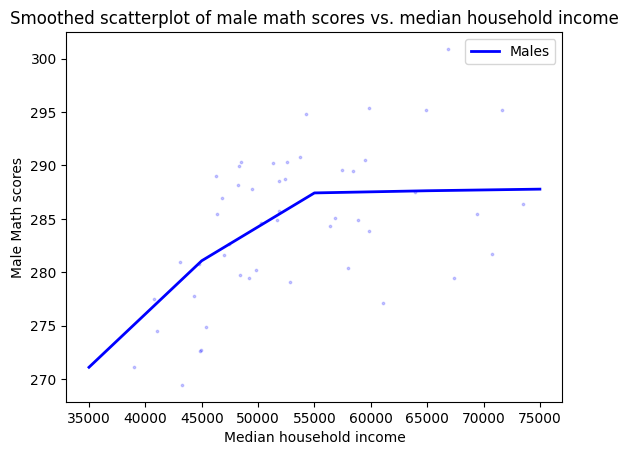

Text(0.5, 0, 'Median household income')

Text(0, 0.5, 'Female Math scores')

Text(0.5, 1.0, 'Smoothed scatterplot of female math scores vs. median household income')

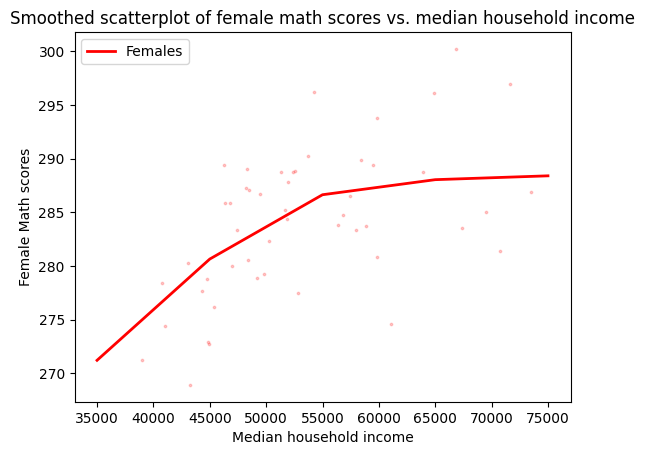

In [33]:
# Part B
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

x = acs_wmath['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars']
y_male = acs_wmath['math_male_2013']
y_female = acs_wmath['math_female_2013']

# Means and SD for each income group
bin_means, bin_edges, _ = stats.binned_statistic(x, y_male, bins=20, range=(0, 200000), statistic='mean')
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

bin_means_female, _, _ = stats.binned_statistic(x, y_female, bins=bin_edges, statistic='mean')

# Plot smoothed scatterplot for males
plt.scatter(x, y_male, s=3, alpha=0.2, color='blue')
plt.plot(bin_centers, bin_means, color='blue', linewidth=2, label='Males')
plt.xlabel('Median household income')
plt.ylabel('Male Math scores')
plt.title('Smoothed scatterplot of male math scores vs. median household income')
plt.legend()
plt.show()

# Plot smoothed scatterplot for females
plt.scatter(x, y_female, s=3, alpha=0.2, color='red')
plt.plot(bin_centers, bin_means_female, color='red', linewidth=2, label='Females')
plt.xlabel('Median household income')
plt.ylabel('Female Math scores')
plt.title('Smoothed scatterplot of female math scores vs. median household income')
plt.legend()
plt.show()






In [34]:
# Part C
# Correlation between male performance and median household income
corr_male_income = np.corrcoef(acs_wmath['math_male_2013'], acs_wmath['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])[0,1]

# Correlation between female performance and median household income
corr_female_income = np.corrcoef(acs_wmath['math_female_2013'], acs_wmath['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])[0,1]

# Correlation between indicator variable and median household income
corr_indicator_income = np.corrcoef(acs_wmath['male_better_than_female'], acs_wmath['acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars'])[0,1]

corr_male_income
corr_female_income
corr_indicator_income

0.5073471931940418

0.5433780349589302

-0.03387519833365422

In [35]:
#D

# In states with higher median household income, boys tend to perform better than boys in states with lower MHI (positive correlation between male performance and MHI).
# In states with higher median household income, girls tend to perform better than girls in states with lower MHI (positive correlation between female performance and MHI).
# There is a weak negative correlation between the indicator variable and MHI, indicating that in states with higher MHI, the gender disparity in math performance tends to be smaller.

## 4.3 Predicting disparities (10 points)

**A.** Read in the raw `acs_wmath` data again (this loses the variables you created above)

**B.** Construct a binary indicator variable for male score > female score  for each year - for full credit, do so without repeating the difference code for each of the four years: name these according to following convention: `outcome_male_higher_female_year` where year is 2013, 2015, 2017, or 2019 (e.g., 2013: `outcome_male_higher_female_2013`). After this, remove the raw math scores as columns in the data (so filter out any column with the word math)

**C.** Melt the data (`acs_wmath`) to long where instead of wide years, years are repeated within state; the ACS vars will also be repeated since we only pulled one year. In other words, reshape the data from "wide format", where each state is a row and we have separate columns for each year, to "long format", where states are repeated four times: once for each year in the data (2013, 2015, 2017, 2019)

**D.** Split into train-test split at state level (so all years in same state -> either all in train or all test). Randomize 35 states to train; 15 states in test. 

**E.** Normalize the features to mean 0, variance 1 and estimate a decision tree with a max depth of 5. 

- **Hint:** The ML literature recommends using the training set scaler to transform the test set, rather than using a unique scaler to initialize each one. The reasons are discussed here: https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data

**F.** Interpret the feature importances

**G.** Evaluate the precision and recall of that model in the test set states without using the `score`, `precision`, or `recall` functions in sklearn. Briefly interpret: compared to our class example (a high-dimensional feature matrix of yelp reviews with ~15000 observations), why do you think our models perform worse for this set of data/predictors?

**Additional resources:** 

- Feature normalization: https://scikit-learn.org/stable/modules/preprocessing.html

- Definition of precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall

In [36]:
# A. your code here to load data
df = pd.read_pickle("acs_wmath.pkl")


In [37]:
# B. your code here to construct binary indicators for male higher
# Define a function to create binary indicator variable for male score > female score

def create_binary_indicator(df, year):
    male_col = f"math_male_{year}"
    female_col = f"math_female_{year}"
    outcome_col = f"outcome_male_higher_female_{year}"
    df.loc[:, outcome_col] = (df.loc[:, male_col] > df.loc[:, female_col]).astype(int)
    return df


# Apply the function to create the binary indicator variables for each year
for year in [2013, 2015, 2017, 2019]:
    df = create_binary_indicator(df, year)


# Remove the raw math scores from the data
df = df.filter(regex=r'^(?!.*math).*')
df.head()


abbrev FIPS  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0     AK   02                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
1     AL   01                                                                                                                                                                                             0.017019                                                                                                                                                                              0.152765                                                                                                                                                                                             0.026735                                                                                                                                                                                              0.046773                                                                                                                                                         0.029813   
2     AR   05                                                                                                                                                                                             0.018760                                                                                                                                                                              0.137646                                                                                                                                                                                             0.026809                                                                                                                                                                                              0.046808                                                                                                                                                         0.026058   
3     AZ   04                                                                                                                                                                                     

In [38]:
# C. Melt the data (acs_wmath) to long where instead of wide years, years are repeated within state; 
# the ACS vars will also be repeated since we only pulled one year.

id_vars = ['FIPS', 'abbrev']
[id_vars.append(col) for col in df.columns if 'acspredict' in col and 'outcome' not in col]
value_vars = ['outcome_male_higher_female_2013', 'outcome_male_higher_female_2015', 'outcome_male_higher_female_2017', 'outcome_male_higher_female_2019']
df_melt = pd.melt(df, id_vars=id_vars, value_vars=value_vars, var_name='year', value_name='male_higher')
df_melt = df_melt.sort_values(by=['abbrev'])
df_melt


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

FIPS abbrev  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0     02     AK                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
50    02     AK                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
150   02     AK                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
100   02     AK                                                                                                                                                                             

In [44]:
# D. your code here for train/test split
import random

# Get unique states in the data
states = df_melt['abbrev'].unique()

# Shuffle the list of states
random.seed(50)
random.shuffle(states)

# Assign the first 35 states to train, and the remaining 15 to test
train_states = states[:35]
test_states = states[35:]

# Create a new column "split" in the data indicating train or test
df_melt['split'] = df_melt['abbrev'].apply(lambda x: 'train' if x in train_states else 'test')

df_melt





FIPS abbrev  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated  acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated  \
0     02     AK                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
50    02     AK                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
150   02     AK                                                                                                                                                                                             0.022719                                                                                                                                                                              0.067757                                                                                                                                                                                             0.027606                                                                                                                                                                                              0.083986                                                                                                                                                         0.010905   
100   02     AK                                                                                                                                                                             

In [45]:
# E. your code here to normalize features and fit model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Split data into train and test sets
train_data = df_melt[df_melt['split'] == 'train']
test_data = df_melt[df_melt['split'] == 'test']
train_data = train_data.drop(['split', 'abbrev'], axis=1)
test_data = test_data.drop(['split', 'abbrev'], axis=1)


# Split features and target variables
x_list = [col for col in df.columns if 'acspredict' in col]

# X_train - the training set for predictors 
X_train = train_data[x_list]
# y_train - the training set for outcomes
y_train = train_data['male_higher']
# X_test - the test set for predictors
X_test = test_data[x_list]
# y_test - the test set for outcomes
y_test = test_data['male_higher']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit a decision tree regressor with max depth of 5
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)

# Evaluate the model on test data
score = model.score(X_test, y_test)
print("R^2 score:" + str(score))








DecisionTreeClassifier(max_depth=5)

R^2 score:0.5


In [46]:
# F. your code here to interpret feature importances
model.feature_importances_
Df = pd.DataFrame({'name':x_list,'value':model.feature_importances_}).sort_values(by = 'value', ascending = False)
Df

array([0.08494823, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14454473, 0.01858243, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07049097, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33647465, 0.12175713, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03695528, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.18624659, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

name     value
32                                                                                                                  acspredict_household_type__including_living_alone__by_relationshipestimatetotalin households  0.336475
65                                                             acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdsnonrelativesother nonrelatives  0.186247
11                                                                                                                  acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade  0.144545
33                                                                                              acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family households  0.121757
0            acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated  0.084948
26                                                                                                             acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school  0.070491
56                                                                          acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholderfemale  0.036955
12                                                                                                                  acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade  0.018582
48                                                                 acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsnonrelativesunmarried partner  0.000000
54                                                                                           acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily households  0.000000
58                                                          acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholderfemalenot living alone  0.000000
57                                                              acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholderfemaleliving alone  0.000000
45                                                             acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsnonrelativeshousemate or roommate  0.000000
55                                                                                acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholder  0.000000
53                                                                                        acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsspouse  0.000000
49                                                                               acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsother relatives  0.000000
46                                                                acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin family householdsnonrelativesother nonrelatives  0.000000
60                                                                acspredict_household_type__including_living_alone__by_relationshipestimatetotalin householdsin nonfamily householdshouseholdermaleliving alone  0.000000
47                                         

In [42]:
# G. your code here to evaluate model
# Predict on test set
y_pred = model.predict(X_test)
true_pos = sum((y_test == 1) & (y_pred == 1))
false_pos = sum((y_test == 0) & (y_pred == 1))
false_neg = sum((y_test == 1) & (y_pred == 0))

# Precision and Recall
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print('Precision:', precision)
print('Recall:', recall)


Precision: 0.5833333333333334
Recall: 0.45161290322580644


In [43]:
#our models perform worse for this set of data/predictors because we have fewer observations and features to train our model on.